# Dataset Comparison: Test Dataset vs Forecast Results

This notebook compares the actual test dataset values with the forecasted values from the N-BEATS model, using denormalized (actual) values for meaningful interpretation.

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [9]:
# Load the datasets
print("Loading datasets...")

# Load test dataset
test_data = pd.read_csv('processed_test_dataset.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Load forecast results
forecast_data = pd.read_csv('forecast_final_with_actual.csv')
forecast_data['Time'] = pd.to_datetime(forecast_data['Time'])

# Load scaling parameters
with open('scaling_parameters.json', 'r') as f:
    scaling_params = json.load(f)

print("Dataset shapes:")
print(f"Test data: {test_data.shape}")
print(f"Forecast data: {forecast_data.shape}")
print(f"\nScaling parameters: {scaling_params}")

# Display first few rows of each dataset
print("\n" + "="*50)
print("TEST DATASET (First 5 rows):")
print(test_data.head())

print("\n" + "="*50)
print("FORECAST DATASET (First 5 rows):")
print(forecast_data.head())

Loading datasets...
Dataset shapes:
Test data: (28, 2)
Forecast data: (30, 6)

Scaling parameters: {'min_balance': 85.18, 'max_balance': 168354.71, 'range': 168269.53}

TEST DATASET (First 5 rows):
        Date   Balance
0 2024-12-06  75893.04
1 2024-12-07  75893.04
2 2024-12-08  75893.04
3 2024-12-09  50893.04
4 2024-12-10  50893.04

FORECAST DATASET (First 5 rows):
        Time  Forecast_Balance  Denormalized_Actual  Day_Number  \
0 2024-12-04          0.696085           117215.020           1   
1 2024-12-05          0.705094           118731.055           2   
2 2024-12-06          0.727588           122516.125           3   
3 2024-12-07          0.717747           120860.160           4   
4 2024-12-08          0.722344           121633.730           5   

   Daily_Change_Actual  Cumulative_Change_Actual  
0                  NaN                    0.0000  
1            1516.0312                 1516.0312  
2            3785.0703                 5301.1016  
3           -1655.9688 

In [10]:
# Function to denormalize values
def denormalize_balance(normalized_value, min_val, max_val):
    """Convert normalized value back to original scale"""
    return normalized_value * (max_val - min_val) + min_val

# Denormalize forecast values
forecast_data['Forecast_Balance_Denormalized'] = denormalize_balance(
    forecast_data['Forecast_Balance'], 
    scaling_params['min_balance'], 
    scaling_params['max_balance']
)

print("Denormalized forecast values:")
print("Original Forecast (normalized):", forecast_data['Forecast_Balance'].head().values)
print("Denormalized Forecast:", forecast_data['Forecast_Balance_Denormalized'].head().values)
print("Denormalized Actual (from file):", forecast_data['Denormalized_Actual'].head().values)

# Check date ranges
print(f"\nDate ranges:")
print(f"Test data: {test_data['Date'].min()} to {test_data['Date'].max()}")
print(f"Forecast data: {forecast_data['Time'].min()} to {forecast_data['Time'].max()}")

# Find overlapping dates
forecast_dates = set(forecast_data['Time'].dt.date)
test_dates = set(test_data['Date'].dt.date)
overlapping_dates = forecast_dates.intersection(test_dates)

print(f"\nOverlapping dates: {len(overlapping_dates)}")
print(f"Overlapping date range: {min(overlapping_dates)} to {max(overlapping_dates)}")

Denormalized forecast values:
Original Forecast (normalized): [0.6960847  0.7050942  0.7275883  0.71774715 0.72234434]
Denormalized Forecast: [117215.02530919 118731.04963973 122516.1212745  120860.15558934
 121633.72258996]
Denormalized Actual (from file): [117215.02  118731.055 122516.125 120860.16  121633.73 ]

Date ranges:
Test data: 2024-12-06 00:00:00 to 2025-01-02 00:00:00
Forecast data: 2024-12-04 00:00:00 to 2025-01-02 00:00:00

Overlapping dates: 28
Overlapping date range: 2024-12-06 to 2025-01-02


In [11]:
# Merge datasets for comparison
# Rename columns for clarity
test_data_renamed = test_data.rename(columns={'Date': 'Time', 'Balance': 'Actual_Test_Balance'})
forecast_data_renamed = forecast_data.rename(columns={'Time': 'Time'})

# Merge on date
comparison_df = pd.merge(
    test_data_renamed[['Time', 'Actual_Test_Balance']], 
    forecast_data_renamed[['Time', 'Forecast_Balance_Denormalized', 'Denormalized_Actual']], 
    on='Time', 
    how='inner'
)

print(f"Merged dataset shape: {comparison_df.shape}")
print("\nComparison dataset:")
print(comparison_df.head(10))

# Calculate differences and errors
comparison_df['Forecast_Error'] = comparison_df['Forecast_Balance_Denormalized'] - comparison_df['Actual_Test_Balance']
comparison_df['Absolute_Error'] = abs(comparison_df['Forecast_Error'])
comparison_df['Percentage_Error'] = (comparison_df['Forecast_Error'] / comparison_df['Actual_Test_Balance']) * 100
comparison_df['Absolute_Percentage_Error'] = abs(comparison_df['Percentage_Error'])

print(f"\nError Statistics:")
print(f"Mean Absolute Error (MAE): {comparison_df['Absolute_Error'].mean():.2f}")
print(f"Root Mean Square Error (RMSE): {np.sqrt((comparison_df['Forecast_Error']**2).mean()):.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {comparison_df['Absolute_Percentage_Error'].mean():.2f}%")
print(f"Mean Forecast Error (Bias): {comparison_df['Forecast_Error'].mean():.2f}")

# Show detailed comparison
print(f"\nDetailed Comparison:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(comparison_df.round(2))

Merged dataset shape: (28, 4)

Comparison dataset:
        Time  Actual_Test_Balance  Forecast_Balance_Denormalized  \
0 2024-12-06             75893.04                  122516.121274   
1 2024-12-07             75893.04                  120860.155589   
2 2024-12-08             75893.04                  121633.722590   
3 2024-12-09             50893.04                  119120.980622   
4 2024-12-10             50893.04                  113054.241468   
5 2024-12-11             48763.04                  110863.776034   
6 2024-12-12             48763.04                  105554.518997   
7 2024-12-13             48763.04                  101498.146399   
8 2024-12-14             48763.04                   94915.368346   
9 2024-12-15             48763.04                   92558.581944   

   Denormalized_Actual  
0           122516.125  
1           120860.160  
2           121633.730  
3           119120.984  
4           113054.240  
5           110863.780  
6           105554.516  


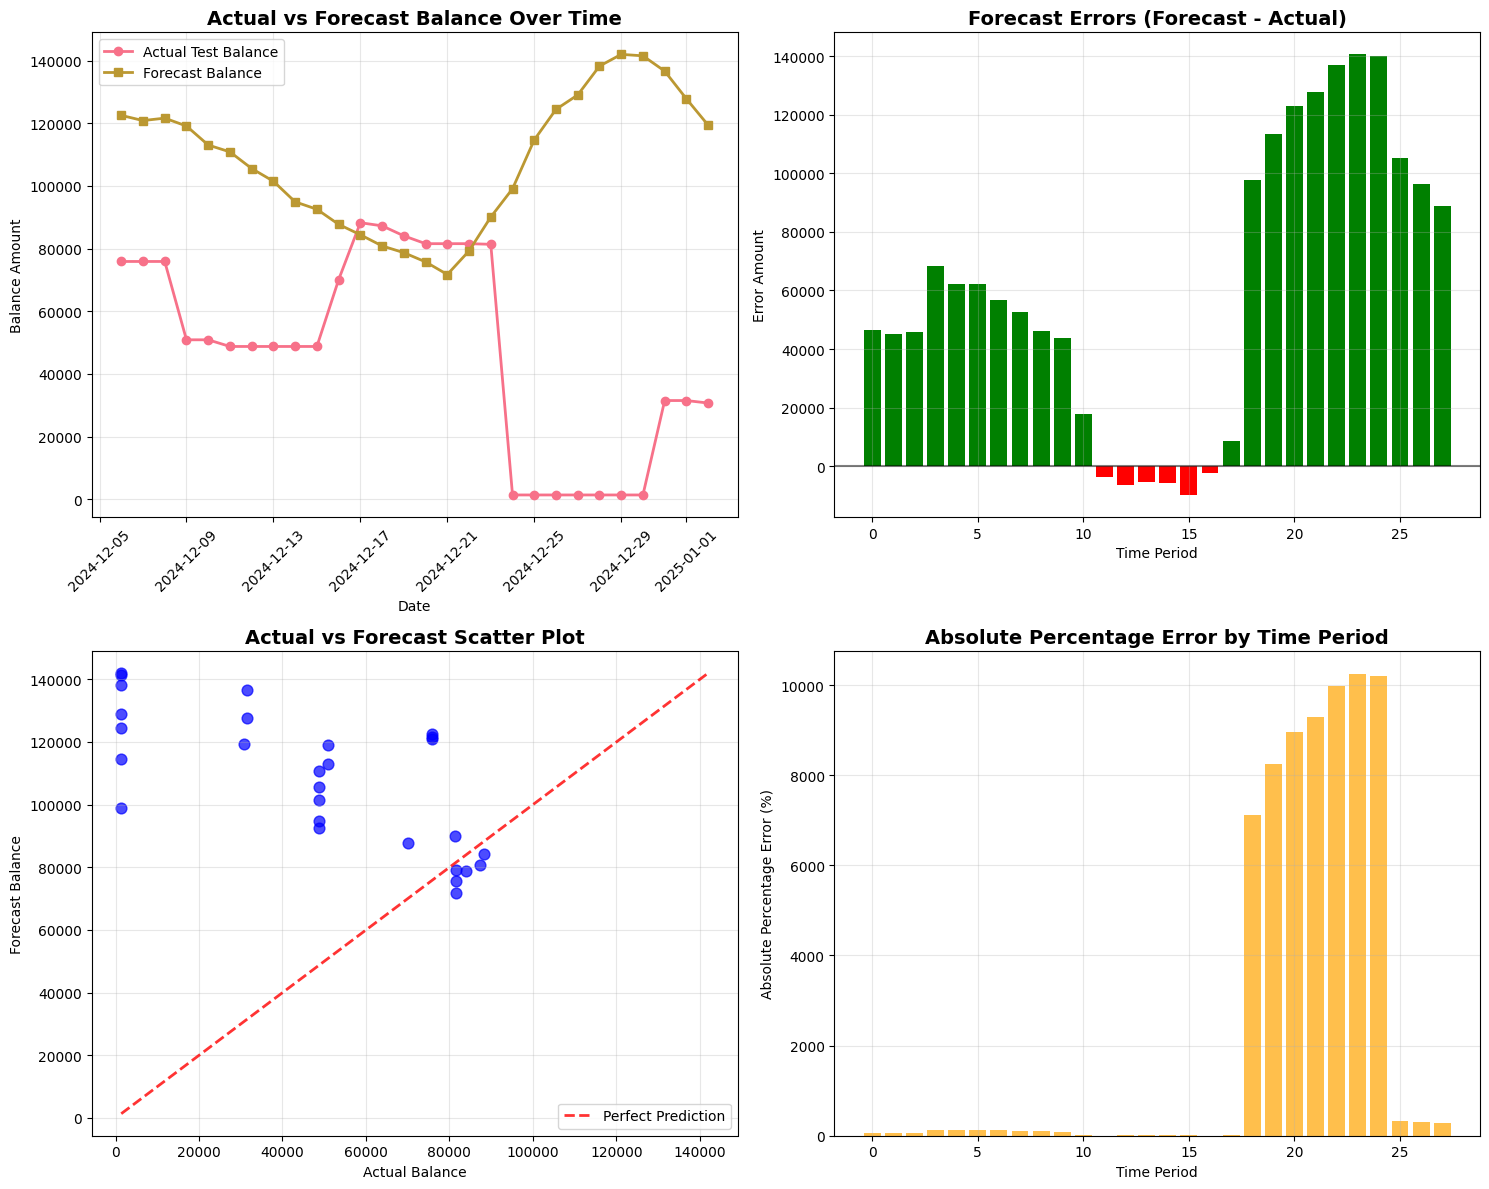

In [12]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Forecast Time Series
axes[0, 0].plot(comparison_df['Time'], comparison_df['Actual_Test_Balance'], 
                label='Actual Test Balance', marker='o', linewidth=2, markersize=6)
axes[0, 0].plot(comparison_df['Time'], comparison_df['Forecast_Balance_Denormalized'], 
                label='Forecast Balance', marker='s', linewidth=2, markersize=6)
axes[0, 0].set_title('Actual vs Forecast Balance Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Balance Amount')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Forecast Errors
axes[0, 1].bar(range(len(comparison_df)), comparison_df['Forecast_Error'], 
               color=['red' if x < 0 else 'green' for x in comparison_df['Forecast_Error']])
axes[0, 1].set_title('Forecast Errors (Forecast - Actual)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Time Period')
axes[0, 1].set_ylabel('Error Amount')
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Scatter plot - Actual vs Forecast
axes[1, 0].scatter(comparison_df['Actual_Test_Balance'], comparison_df['Forecast_Balance_Denormalized'], 
                   alpha=0.7, s=60, color='blue')
min_val = min(comparison_df['Actual_Test_Balance'].min(), comparison_df['Forecast_Balance_Denormalized'].min())
max_val = max(comparison_df['Actual_Test_Balance'].max(), comparison_df['Forecast_Balance_Denormalized'].max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Actual vs Forecast Scatter Plot', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Actual Balance')
axes[1, 0].set_ylabel('Forecast Balance')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Absolute Percentage Error
axes[1, 1].bar(range(len(comparison_df)), comparison_df['Absolute_Percentage_Error'], 
               color='orange', alpha=0.7)
axes[1, 1].set_title('Absolute Percentage Error by Time Period', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Time Period')
axes[1, 1].set_ylabel('Absolute Percentage Error (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Additional Analysis and Summary
print("="*60)
print("COMPREHENSIVE COMPARISON ANALYSIS")
print("="*60)

# Summary statistics
print("\n1. DATASET SUMMARY:")
print(f"   - Number of overlapping dates: {len(comparison_df)}")
print(f"   - Date range: {comparison_df['Time'].min().strftime('%Y-%m-%d')} to {comparison_df['Time'].max().strftime('%Y-%m-%d')}")

print("\n2. ACTUAL TEST BALANCE STATISTICS:")
print(f"   - Mean: {comparison_df['Actual_Test_Balance'].mean():.2f}")
print(f"   - Std Dev: {comparison_df['Actual_Test_Balance'].std():.2f}")
print(f"   - Min: {comparison_df['Actual_Test_Balance'].min():.2f}")
print(f"   - Max: {comparison_df['Actual_Test_Balance'].max():.2f}")

print("\n3. FORECAST BALANCE STATISTICS:")
print(f"   - Mean: {comparison_df['Forecast_Balance_Denormalized'].mean():.2f}")
print(f"   - Std Dev: {comparison_df['Forecast_Balance_Denormalized'].std():.2f}")
print(f"   - Min: {comparison_df['Forecast_Balance_Denormalized'].min():.2f}")
print(f"   - Max: {comparison_df['Forecast_Balance_Denormalized'].max():.2f}")

print("\n4. ERROR METRICS:")
print(f"   - Mean Absolute Error (MAE): {comparison_df['Absolute_Error'].mean():.2f}")
print(f"   - Root Mean Square Error (RMSE): {np.sqrt((comparison_df['Forecast_Error']**2).mean()):.2f}")
print(f"   - Mean Absolute Percentage Error (MAPE): {comparison_df['Absolute_Percentage_Error'].mean():.2f}%")
print(f"   - Mean Forecast Error (Bias): {comparison_df['Forecast_Error'].mean():.2f}")
print(f"   - Max Absolute Error: {comparison_df['Absolute_Error'].max():.2f}")
print(f"   - Min Absolute Error: {comparison_df['Absolute_Error'].min():.2f}")

# Correlation analysis
correlation = comparison_df['Actual_Test_Balance'].corr(comparison_df['Forecast_Balance_Denormalized'])
print(f"\n5. CORRELATION ANALYSIS:")
print(f"   - Pearson correlation coefficient: {correlation:.4f}")

# Performance categorization
high_error_threshold = comparison_df['Absolute_Percentage_Error'].quantile(0.75)
high_error_count = (comparison_df['Absolute_Percentage_Error'] > high_error_threshold).sum()

print(f"\n6. PERFORMANCE CATEGORIZATION:")
print(f"   - High error threshold (75th percentile): {high_error_threshold:.2f}%")
print(f"   - Number of high-error predictions: {high_error_count}")
print(f"   - Percentage of high-error predictions: {(high_error_count/len(comparison_df)*100):.1f}%")

# Direction accuracy
correct_direction = 0
for i in range(1, len(comparison_df)):
    actual_change = comparison_df.iloc[i]['Actual_Test_Balance'] - comparison_df.iloc[i-1]['Actual_Test_Balance']
    forecast_change = comparison_df.iloc[i]['Forecast_Balance_Denormalized'] - comparison_df.iloc[i-1]['Forecast_Balance_Denormalized']
    if (actual_change >= 0 and forecast_change >= 0) or (actual_change < 0 and forecast_change < 0):
        correct_direction += 1

direction_accuracy = (correct_direction / (len(comparison_df) - 1)) * 100 if len(comparison_df) > 1 else 0

print(f"\n7. DIRECTIONAL ACCURACY:")
print(f"   - Correct direction predictions: {correct_direction}/{len(comparison_df)-1}")
print(f"   - Directional accuracy: {direction_accuracy:.1f}%")

COMPREHENSIVE COMPARISON ANALYSIS

1. DATASET SUMMARY:
   - Number of overlapping dates: 28
   - Date range: 2024-12-06 to 2025-01-02

2. ACTUAL TEST BALANCE STATISTICS:
   - Mean: 47584.56
   - Std Dev: 32120.38
   - Min: 1373.04
   - Max: 88263.04

3. FORECAST BALANCE STATISTICS:
   - Mean: 107998.82
   - Std Dev: 21614.80
   - Min: 71730.45
   - Max: 141990.51

4. ERROR METRICS:
   - Mean Absolute Error (MAE): 62813.78
   - Root Mean Square Error (RMSE): 77804.77
   - Mean Absolute Percentage Error (MAPE): 2358.07%
   - Mean Forecast Error (Bias): 60414.26
   - Max Absolute Error: 140617.47
   - Min Absolute Error: 2308.18

5. CORRELATION ANALYSIS:
   - Pearson correlation coefficient: -0.7157

6. PERFORMANCE CATEGORIZATION:
   - High error threshold (75th percentile): 2029.54%
   - Number of high-error predictions: 7
   - Percentage of high-error predictions: 25.0%

7. DIRECTIONAL ACCURACY:
   - Correct direction predictions: 13/27
   - Directional accuracy: 48.1%


In [14]:
# Save comparison results
print("="*60)
print("SAVING COMPARISON RESULTS")
print("="*60)

# Create a comprehensive comparison dataframe with all metrics
final_comparison = comparison_df.copy()
final_comparison['Time'] = final_comparison['Time'].dt.strftime('%Y-%m-%d')

# Round numerical values for better readability
numerical_columns = ['Actual_Test_Balance', 'Forecast_Balance_Denormalized', 'Denormalized_Actual',
                    'Forecast_Error', 'Absolute_Error', 'Percentage_Error', 'Absolute_Percentage_Error']
for col in numerical_columns:
    if col in final_comparison.columns:
        final_comparison[col] = final_comparison[col].round(2)

# Save to CSV
output_filename = 'test_vs_forecast_comparison.csv'
final_comparison.to_csv(output_filename, index=False)
print(f"✓ Detailed comparison saved to: {output_filename}")

# Create summary report
summary_report = {
    'Analysis_Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Number_of_Data_Points': len(comparison_df),
    'Date_Range_Start': comparison_df['Time'].min().strftime('%Y-%m-%d'),
    'Date_Range_End': comparison_df['Time'].max().strftime('%Y-%m-%d'),
    'Mean_Absolute_Error': round(comparison_df['Absolute_Error'].mean(), 2),
    'Root_Mean_Square_Error': round(np.sqrt((comparison_df['Forecast_Error']**2).mean()), 2),
    'Mean_Absolute_Percentage_Error': round(comparison_df['Absolute_Percentage_Error'].mean(), 2),
    'Mean_Forecast_Bias': round(comparison_df['Forecast_Error'].mean(), 2),
    'Correlation_Coefficient': round(correlation, 4),
    'Directional_Accuracy_Percent': round(direction_accuracy, 1),
    'Actual_Balance_Mean': round(comparison_df['Actual_Test_Balance'].mean(), 2),
    'Actual_Balance_Std': round(comparison_df['Actual_Test_Balance'].std(), 2),
    'Forecast_Balance_Mean': round(comparison_df['Forecast_Balance_Denormalized'].mean(), 2),
    'Forecast_Balance_Std': round(comparison_df['Forecast_Balance_Denormalized'].std(), 2),
}

# Save summary report
import json
summary_filename = 'comparison_summary_report.json'
with open(summary_filename, 'w') as f:
    json.dump(summary_report, f, indent=4)
print(f"✓ Summary report saved to: {summary_filename}")

# Display the saved comparison data
print(f"\n✓ COMPARISON COMPLETE!")
print(f"Files created:")
print(f"  1. {output_filename} - Detailed comparison data")
print(f"  2. {summary_filename} - Summary metrics")

print(f"\nFinal Comparison Table (First 10 rows):")
print(final_comparison.head(10).to_string(index=False))

print(f"\nKey Findings:")
print(f"  • The forecast has a correlation of {correlation:.3f} with actual values")
print(f"  • Average absolute error is {comparison_df['Absolute_Error'].mean():.2f}")
print(f"  • Average percentage error is {comparison_df['Absolute_Percentage_Error'].mean():.1f}%")
print(f"  • Directional accuracy is {direction_accuracy:.1f}%")

SAVING COMPARISON RESULTS
✓ Detailed comparison saved to: test_vs_forecast_comparison.csv
✓ Summary report saved to: comparison_summary_report.json

✓ COMPARISON COMPLETE!
Files created:
  1. test_vs_forecast_comparison.csv - Detailed comparison data
  2. comparison_summary_report.json - Summary metrics

Final Comparison Table (First 10 rows):
      Time  Actual_Test_Balance  Forecast_Balance_Denormalized  Denormalized_Actual  Forecast_Error  Absolute_Error  Percentage_Error  Absolute_Percentage_Error
2024-12-06             75893.04                      122516.12            122516.12        46623.08        46623.08             61.43                      61.43
2024-12-07             75893.04                      120860.16            120860.16        44967.12        44967.12             59.25                      59.25
2024-12-08             75893.04                      121633.72            121633.73        45740.68        45740.68             60.27                      60.27
2024-12-09

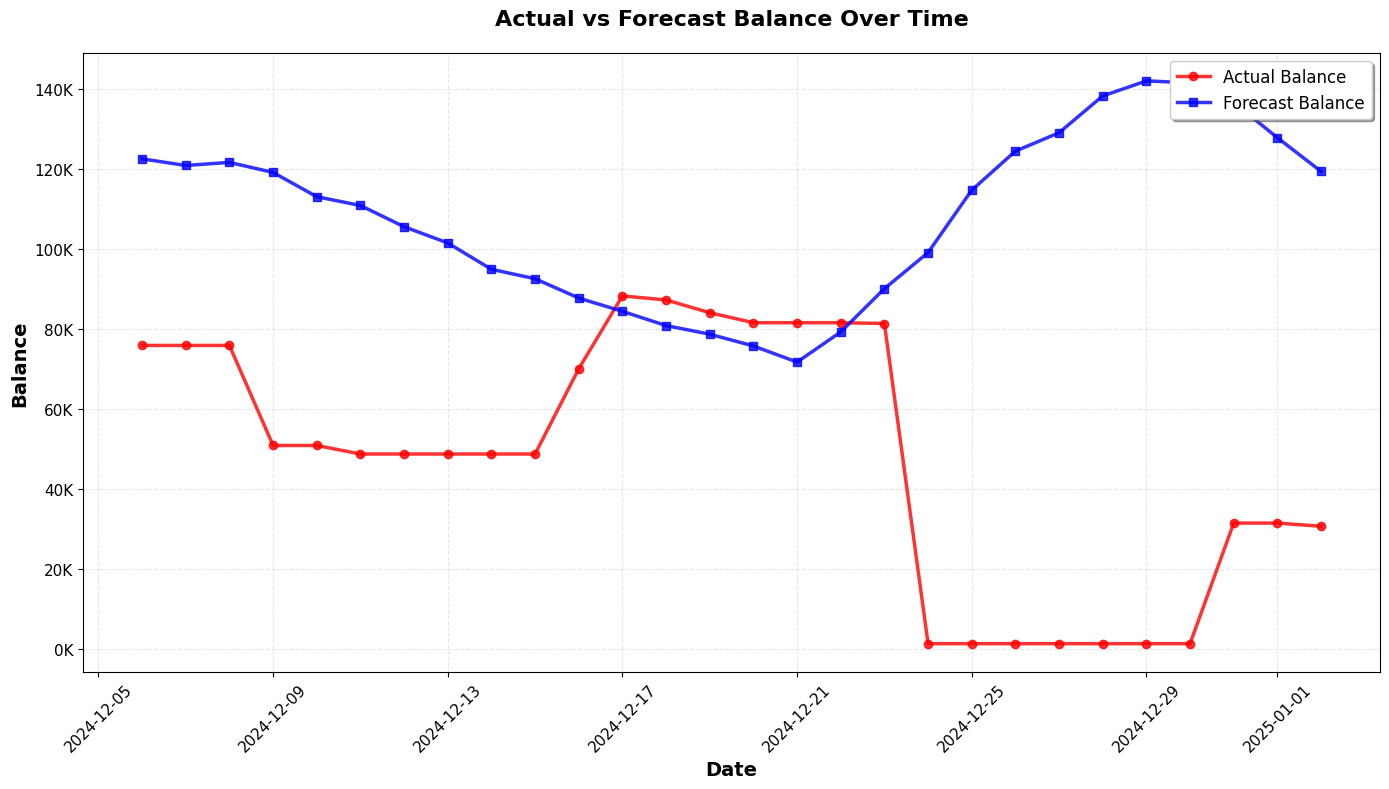

Date Range: 2024-12-06 to 2025-01-02
Actual Balance Range: 1373.04 to 88263.04
Forecast Balance Range: 71730.45 to 141990.51


In [16]:
# Create clean diagram: Date vs Balance (Red=Actual, Blue=Forecast)
plt.figure(figsize=(14, 8))

# Plot actual values in red
plt.plot(comparison_df['Time'], comparison_df['Actual_Test_Balance'], 
         color='red', linewidth=2.5, marker='o', markersize=6, 
         label='Actual Balance', alpha=0.8)

# Plot forecast values in blue
plt.plot(comparison_df['Time'], comparison_df['Forecast_Balance_Denormalized'], 
         color='blue', linewidth=2.5, marker='s', markersize=6, 
         label='Forecast Balance', alpha=0.8)

# Customize the plot
plt.title('Actual vs Forecast Balance Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Balance', fontsize=14, fontweight='bold')

# Format the legend
plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)

# Format the axes
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Format y-axis to show values in thousands/millions
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K' if x < 1000000 else f'{x/1000000:.1f}M'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics for the plot
print(f"Date Range: {comparison_df['Time'].min().strftime('%Y-%m-%d')} to {comparison_df['Time'].max().strftime('%Y-%m-%d')}")
print(f"Actual Balance Range: {comparison_df['Actual_Test_Balance'].min():.2f} to {comparison_df['Actual_Test_Balance'].max():.2f}")
print(f"Forecast Balance Range: {comparison_df['Forecast_Balance_Denormalized'].min():.2f} to {comparison_df['Forecast_Balance_Denormalized'].max():.2f}")